In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def process_torch_log(logfname,epoch_size):
    train = {}
    test = {}
    
    import re
    trainp = re.compile('Epoch:\s+\[(\d+)\]\[(\d+)\/(\d+)\]\s+Time\s+(\d+\.\d+)\s+Err\s+(\d+\.\d+)\s+Top1\-\%\:\s+(\d+\.\d+)\s+LR\s+([\d|e|\.\-]+)\s+DataLoadingTime\s+(\d+\.\d+)*')
    testp = re.compile('Epoch:\s+\[(\d+)\]\[TESTING\s+SUMMARY\]\s+Total\s+Time\(s\):\s+(\d+\.\d+)\s+average\s+loss\s+\(per\s+batch\):\s+(\d+\.\d+)\s+accuracy\s+\[Center\]\(\%\):\s+top\-1\s+(\d+\.\d+)')
    #added top5 accuracy
    testpnew = re.compile('Epoch:\s+\[NEW\]\s*\[(\d+)\]\[TESTING\s+SUMMARY\]\s+Total\s+Time\(s\):\s+(\d+\.\d+)\s+average\s+loss\s+\(per\s+batch\):\s+(\d+\.\d+)\s+accuracy\s+\[Center\]\(\%\):\s+top\-1\s+(\d+\.\d+)\s+top\-5\s+(\d+\.\d+)')
    
    with open(logfname) as log:
        contents = log.readlines()
        print len(contents)," of log lines to process"
        iteration_logs = [ trainp.match(l) for l in contents if trainp.match(l)]
        test_logs = [testp.match(l) for l in contents if testp.match(l)]
        testnew_logs = [testpnew.match(l) for l in contents if testpnew.match(l)]
        print len(iteration_logs)," lines of iteration logs to process"
        print len(test_logs)," lines of of test logs to process"
        print len(testnew_logs)," lines of of [NEW] test logs to process"
        it = 0
        epoch = 0
        print "Start Processing Logs... "
        epochSize = 0
        for log in iteration_logs:
            #print log.groups()
            epoch,it,total_iters,time,err,top1,lr,loadt= [eval(n) for n in log.groups()]
            train[epoch] = train.get(epoch, {})
            epochSize = total_iters # should be same for all epochs
            if epochSize != epoch_size:
                print "Warning: epoch size settings is not equal to the epoch size detected!"
            train[epoch][it] = {'loss':err,'lr':lr,'top1':top1}
            #train[epoch][1][it] = err
            #train[epoch][2][it] = lr
            #train[epoch][3][it] = top1
        if len(testnew_logs) != 0 :
            for log in testnew_logs:
                epoch,total_time,avg_loss,top1,top5 = [eval(n) for n in log.groups()]
                test[epoch] = test.get(epoch, {})
                test[epoch]['loss'] = avg_loss
                test[epoch]['top1'] = top1
                test[epoch]['top5'] = top5
        else:
            if len(test_logs) == 0:
                print "no test logs found!"
            for log in test_logs:
                epoch,total_time,avg_loss,top1 = [eval(n) for n in log.groups()]
                test[epoch] = test.get(epoch, {})
                test[epoch]['loss'] = avg_loss
                test[epoch]['top1'] = top1
                test[epoch]['top5'] = 0
        print "Done Log Processing."
        #prepare ndarrays for plotting, conform with caffe analyse result format
        train_tbl = np.zeros((4,len(train.keys()*epochSize))) #iter,trainloss3
        test_tbl = np.zeros((5,len(test.keys()))) #iter,lr,trainloss3,testtop1,testtop5
        test_tbl_epoch = np.zeros((5,len(test.keys())))
        #turn test into nd arrays and sync with caffe result tables
        idx_train = 0
        for epoch,epochData in sorted(train.items()):
            for iter,iterData in sorted(epochData.items()):
                train_tbl[0][idx_train] = (epoch-1)*epochSize + iter # iteration
                train_tbl[1][idx_train] = epoch + float(iter)/epochSize # epoch
                train_tbl[2][idx_train] = iterData['lr'] #lr
                train_tbl[3][idx_train] = iterData['loss'] #loss
                idx_train = idx_train + 1
        idx_test = 0
        for epoch,epochData in sorted(test.items()):
            test_tbl[0][idx_test] = epoch*epochSize
            test_tbl[1][idx_test] = train[epoch][epochSize]['lr']
            test_tbl[2][idx_test] = train[epoch][epochSize]['loss'] # total loss
            test_tbl[3][idx_test] = epochData['top1']/100.0
            test_tbl[4][idx_test] = epochData['top5']/100.0 #top5
            test_tbl_epoch[0][idx_test] = epoch
            test_tbl_epoch[1][idx_test] = train[epoch][epochSize]['lr']
            test_tbl_epoch[2][idx_test] = train[epoch][epochSize]['loss'] # total loss
            test_tbl_epoch[3][idx_test] = epochData['top1']/100.0
            test_tbl_epoch[4][idx_test] = epochData['top5']/100.0 #top5
            idx_test = idx_test + 1
            #test_tbl[4][idx_test] = epochData['top5']
        #return the train, test results and the last epoch and last iteration
        print train_tbl[:,0:idx_train].shape[1],' train record found'
        print test_tbl[:,0:idx_test].shape[1],' test record found'
        print test_tbl_epoch[:,0:idx_test].shape[1],'test epoch record found'
        return train_tbl[:,:idx_train],test_tbl[:,:idx_test],test_tbl_epoch[:,:idx_test],epoch,idx_train

In [4]:
def process_caffe_log(logfname,epoch_size):
    print "processing caffe logs"
    result = {}
    
    import re
    trainiter = re.compile('I(\d\d\d\d\s+\d\d\:\d\d\:\d\d\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+loss\s+=\s+([-+]?(\d+([.,]\d*)?|[.,]\d+)([eE][-+]?\d+)?)')
    trainnetloss3 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Train\s+net\s+output\s+#\d\:\s+loss3\/loss\s+=\s+(\d+.\d+)*')
    trainiterlr = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+sgd_solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+lr\s+=\s+([-+]?(\d+([.,]\d*)?|[.,]\d+)([eE][-+]?\d+)?)')
    testiter = re.compile('I(\d+\s+\d+\:\d+\:\d+.\d+\s+\d+)\s+solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+Testing\s+net\s+\(#\d+\)')
    testnettop1 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Test\s+net\s+output\s+#\d+\:\s+loss3\/top-1\s+=\s+(\d+\.\d+)\s*')
    testnettop5 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Test\s+net\s+output\s+#\d+\:\s+loss3\/top-5\s+=\s+(\d+\.\d+)\s*')
    with open(logfname) as log:
        contents = log.readlines()
        print len(contents)," of log lines to process"
        print "Start Processing Logs..."
        cur_iter = 0
        for log in contents:
            trainiterm = trainiter.match(log)
            trainnetloss3m = trainnetloss3.match(log)
            trainiterlrm = trainiterlr.match(log)
            testiterm = testiter.match(log)
            testnettop1m = testnettop1.match(log)
            testnettop5m = testnettop5.match(log)
            if trainiterm or testiterm:
                cur_iter = eval(trainiterm.group(2) if trainiterm else testiterm.group(2))
                result[cur_iter] = result.get(cur_iter,{})
                if trainiterm :
                    result[cur_iter]['loss'] = eval(trainiterm.group(3))
                #print "current iteration = ",cur_iter
            elif trainiterlrm :
                result[eval(trainiterlrm.group(2))]['lr'] = eval(trainiterlrm.group(3))
            elif trainnetloss3m:
                result[cur_iter]['trainloss3'] = eval(trainnetloss3m.group(2))
            elif testnettop1m :
                result[cur_iter]['testtop1'] = eval(testnettop1m.group(2))
            elif testnettop5m :
                result[cur_iter]['testtop5'] = eval(testnettop5m.group(2))
            else :
                #print "log doesn't match any of the patterns: ",log
                pass
        print "Done Log Processing."
        
        #prepare ndarrays for plotting
        train_tbl = np.zeros((4,len(result.keys()))) #iter,trainloss3
        test_tbl = np.zeros((5,len(result.keys()))) #iter,lr,trainloss3,testtop1,testtop5
        test_tbl_epoch = np.zeros((5,999))
        #print result
        #get all test results with train lr
        idx_train = 0
        idx_test = 0
        idx_test_epoch = 0
        for iter,values in sorted(result.items()):
            #print iter,values
            if values.has_key('trainloss3'):
                train_tbl[0][idx_train] = iter
                train_tbl[1][idx_train] = float(iter)/epoch_size + 1
                train_tbl[2][idx_train] = values['lr']
                train_tbl[3][idx_train] = values['loss']
                idx_train = idx_train + 1
            if values.has_key('testtop1'):
                #print iter,values
                test_tbl[0][idx_test] = iter # iteration
                test_tbl[1][idx_test] = values.get('lr',0)
                test_tbl[2][idx_test] = values.get('loss',0)
                test_tbl[3][idx_test] = values['testtop1']
                test_tbl[4][idx_test] = values['testtop5']
                idx_test = idx_test + 1
                if iter%epoch_size == 0:
                    test_tbl_epoch[0][idx_test_epoch] = int(iter/epoch_size) #epoch
                    test_tbl_epoch[1][idx_test_epoch] = values.get('lr',0)
                    test_tbl_epoch[2][idx_test_epoch] = values.get('loss',0)
                    test_tbl_epoch[3][idx_test_epoch] = values['testtop1']
                    test_tbl_epoch[4][idx_test_epoch] = values['testtop5']
                    idx_test_epoch = idx_test_epoch + 1
        print train_tbl[:,0:idx_train].shape[1],' train record found'
        print test_tbl[:,0:idx_test].shape[1],' test record found'
        print test_tbl_epoch[:,0:idx_test_epoch].shape[1],'test epoch record found'
        #return the errs, top1 accuracy and the last epoch and last iteration
        return train_tbl[:,0:idx_train],test_tbl[:,0:idx_test],test_tbl_epoch[:,0:idx_test_epoch],idx_test_epoch,iter%epoch_size

In [5]:
def process_log(fmat,log,epoch_size):
    if fmat=='caffe': 
        return process_caffe_log(log,epoch_size)
    elif fmat == 'torch':
        return process_torch_log(log,epoch_size)
    else:
        print "unknown log format",fmat
        return None

In [6]:
tests = [
    ('caffe','caffe-32-step','/home/user/shane/caffe/yiheng-googlenetv2-bs32-1GPU.log',128*10000/32),
    #('256-step','/home/user/shane/caffe/yiheng-googlenetv2-bs32x8-8GPU.log',128*10000/256),
    ('caffe','caffe-512-step','/home/user/shane/caffe/gv2-bs64x8-8GPU-step.log',128*10000/512),
    #('512-triangular2','/home/user/shane/caffe/gv2-bs64x8-8GPU-tri2.log',128*10000/512),
    #('caffe','caffe-512-step-scaled-stepsize','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-stepsize-scaled.log',128*10000/512),
    #('512-hybrid(step+tri2)','/home/user/shane/caffe/gv2-bs64x8-8GPU-tri2-boost-step-from50000.log',128*10000/512),
    #('caffe','caffe-512-step-rescaled-linear','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-16x.log',128*10000/512),
    #('caffe','caffe-512-step-rescaled-3/4linear','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-12x.log',128*10000/512),
    #('512-step-rescaled-12x','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-8x.log',128*10000/512),
    ('caffe','caffe-512-step-rescaled-1/2linear','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-8x.log',128*10000/512),
    #('caffe','caffe-512-step-rescaled-1/4linear','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-4x.log',128*10000/512),
    #('torch','torch-128-original','/home/user/shane/soumith-imgnet-training/torch-yiheng-googlenetv2-bs128-8GPU.log',128*10000/128),
    #('torch','torch-256-original','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs256-8GPU.log',128*10000/256),
    ('torch','torch-896-original','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU.log',1430),
    ('torch','torch-896-triangular2','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU-triangular2-t1.log',1430),
    ('torch','896-triangular2-hybrid','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU-triangular2-t2.log',1430),
    ('torch','torch-896-step-0.36','/home/user/shane/soumith-imgnet-training/torch-gv2-bs896-8GPU-step-0.5linear.log',1430),
    ]
result_tbls = []
for (fmat,label,log,epoch_size) in tests:
    print 'TEST ===',label,'==='
    print log
    train1,test1,test1_epoch,last_epoch,last_it = process_log(fmat,log,epoch_size)
    result_tbls.append({'label':label,'train_result':train1,'test_result':test1,'test_result_epoch':test1_epoch})

TEST === caffe-32-step ===
/home/user/shane/caffe/yiheng-googlenetv2-bs32-1GPU.log
processing caffe logs
170372  of log lines to process
Start Processing Logs...
Done Log Processing.
30000  train record found
124  test record found
30 test epoch record found
TEST === caffe-512-step ===
/home/user/shane/caffe/gv2-bs64x8-8GPU-step.log
processing caffe logs
18913  of log lines to process
Start Processing Logs...
Done Log Processing.
1875  train record found
30  test record found
30 test epoch record found
TEST === caffe-512-step-rescaled-1/2linear ===
/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-8x.log
processing caffe logs
18969  of log lines to process
Start Processing Logs...
Done Log Processing.
1875  train record found
30  test record found
30 test epoch record found
TEST === torch-896-original ===
/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU.log
80166  of log lines to process
78650  lines of iteration logs to process
55  lines of of test logs 

In [7]:
#### formattings
def plot_formats(num):
    #from itertools import cycle
    #lines = ["-","--"]
    #linecycler = cycle(lines)    
    lwidths = np.linspace(1,4,num)
    formats = [{'lw':lw} for lw in lwidths]
    return formats

In [8]:
def plot_lr_iter(position,result_tbls,lineformats):
    ymax = 0
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': learning rate vs. iteration')
    for result,lineformat in zip(result_tbls,lineformats):
        ymax = max(ymax,max(result['train_result'][2,:]))
        plt.plot(result['train_result'][0,:],result['train_result'][2,:],label=result['label'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('learning rate')
    plt.ylim((0,ymax*1.05))

In [9]:
def plot_lr_epoch(position,result_tbls,lineformats):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': learning rate vs. epoch')
    ymax = 0
    for result in result_tbls:
        ymax = max(ymax,max(result['train_result'][2,:]))
        plt.plot(result['train_result'][1,:],result['train_result'][2,:],label=result['label'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('learning rate')
    plt.ylim((0,ymax*1.05))

In [10]:
def plot_loss_iter(position,result_tbls,lineformats):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': train loss vs. iteration')
    for result,lineformat in zip(result_tbls,lineformats):
        plt.plot(result['train_result'][0,:],result['train_result'][3,:],label=result['label'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('train loss')

In [11]:
def plot_loss_epoch(position,result_tbls,lineformats):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': train loss vs. epoch')
    for result in result_tbls:
        plt.plot(result['train_result'][1,:],result['train_result'][3,:],label=result['label'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('train loss')

In [12]:
def plot_top1_iter(position,result_tbls,lineformats):
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top1 accr vs. iteration')
    for result in result_tbls:
        plt.plot(result['test_result'][0,:],result['test_result'][3,:],label=result['label'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('top1 accr')
    plt.ylim((0,1))
    plt.xlim(xmin=0)

In [13]:
def plot_top5_iter(position,result_tbls,lineformats):
    #plot the error
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top5 accr vs. iteration')
    for result in result_tbls:
        plt.plot(result['test_result'][0,:],result['test_result'][4,:],label=result['label'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.ylim((0,1))
    plt.xlim(xmin=0)
    #=========== annotation begin ===========
    #the spot on 256-step
    #spot=(result_tbls[1]['test_result'][0,20],result_tbls[1]['test_result'][4,20])
    #plt.scatter([spot[0], ], [spot[1], ], 50, color='grey')
    #plt.annotate(r'iteration 200000',
    #             xy=(spot[0], spot[1]), xycoords='data',
    #             xytext=(+10, -50), textcoords='offset points', fontsize=10,
    #             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    #the spot on 512-triangular2
    #spot=(result_tbls[3]['test_result'][0,98],result_tbls[3]['test_result'][4,98])
    #plt.scatter([spot[0], ], [spot[1], ], 50, color='grey')
    #plt.annotate(r'iteration 100000',
    #             xy=(spot[0], spot[1]), xycoords='data',
    #             xytext=(+10, +20), textcoords='offset points', fontsize=10,
    #             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    #=========== annotation end ===========
    plt.xlim(xmin=0)
    plt.xlabel('iteration')
    plt.ylabel('top5 accr')

In [14]:
def plot_top1_epoch(position,result_tbls,lineformats):
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top1 accr vs. epoch')
    for result in result_tbls:
        plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][3,:],label=result['label'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('top1 accr')
    plt.ylim((0,1))
    plt.xlim(xmin=0)

In [15]:
def plot_top5_epoch(position,result_tbls,lineformats):
    #plot the error
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top5 accr vs. epoch')
    for result in result_tbls:
        plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][4,:],label=result['label'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('top5 accr')
    plt.ylim((0,1))
    plt.xlim(xmin=0)


In [16]:
def find_final_accuracy(testspecs,result_tbls):
    for test,result in zip(testspecs,result_tbls):
        print 'TEST MAX ACCURACY:',result['label']
        #am = result['test_result'].max(axis=1)
        if result['test_result'].shape[1] == 0:
            print "No test result available yet"
            continue
        maxind = result['test_result'].argmax(axis=1)
        print 'maxiter_top1 = ',result['test_result'][0,maxind[3]],'max_epoch_top1=',int(result['test_result'][0,maxind[3]]/test[3]),'top1acc =',result['test_result'][3,maxind[3]],'top5acc =',result['test_result'][4,maxind[3]]
        print 'maxiter_top5 = ',result['test_result'][0,maxind[4]],'max_epoch_top1=',int(result['test_result'][0,maxind[4]]/test[3]),'top1acc =',result['test_result'][3,maxind[4]],'top5acc =',result['test_result'][4,maxind[4]]
        maxind = result['train_result'].argmax(axis=1)
        minind = result['train_result'].argmin(axis=1)
        print 'max lr = ',result['train_result'][2,maxind[2]],'min lr = ',result['train_result'][2,minind[2]]
        

TEST MAX ACCURACY: caffe-32-step
maxiter_top1 =  1200000.0 max_epoch_top1= 30 top1acc = 0.712969 top5acc = 0.902656
maxiter_top5 =  1190000.0 max_epoch_top1= 29 top1acc = 0.709594 top5acc = 0.904813
max lr =  0.045 min lr =  2.17737e-05
TEST MAX ACCURACY: caffe-512-step
maxiter_top1 =  65000.0 max_epoch_top1= 26 top1acc = 0.5355 top5acc = 0.7825
maxiter_top5 =  70000.0 max_epoch_top1= 28 top1acc = 0.532938 top5acc = 0.783562
max lr =  0.045 min lr =  0.0287208
TEST MAX ACCURACY: caffe-512-step-rescaled-1/2linear
maxiter_top1 =  67500.0 max_epoch_top1= 27 top1acc = 0.711187 top5acc = 0.9025
maxiter_top5 =  67500.0 max_epoch_top1= 27 top1acc = 0.711187 top5acc = 0.9025
max lr =  0.36 min lr =  0.000174189
TEST MAX ACCURACY: torch-896-original
maxiter_top1 =  78650.0 max_epoch_top1= 55 top1acc = 0.6802 top5acc = 0.0
maxiter_top5 =  1430.0 max_epoch_top1= 1 top1acc = 0.1186 top5acc = 0.0
max lr =  0.01 min lr =  0.0001
TEST MAX ACCURACY: torch-896-triangular2
maxiter_top1 =  24310.0 max_ep

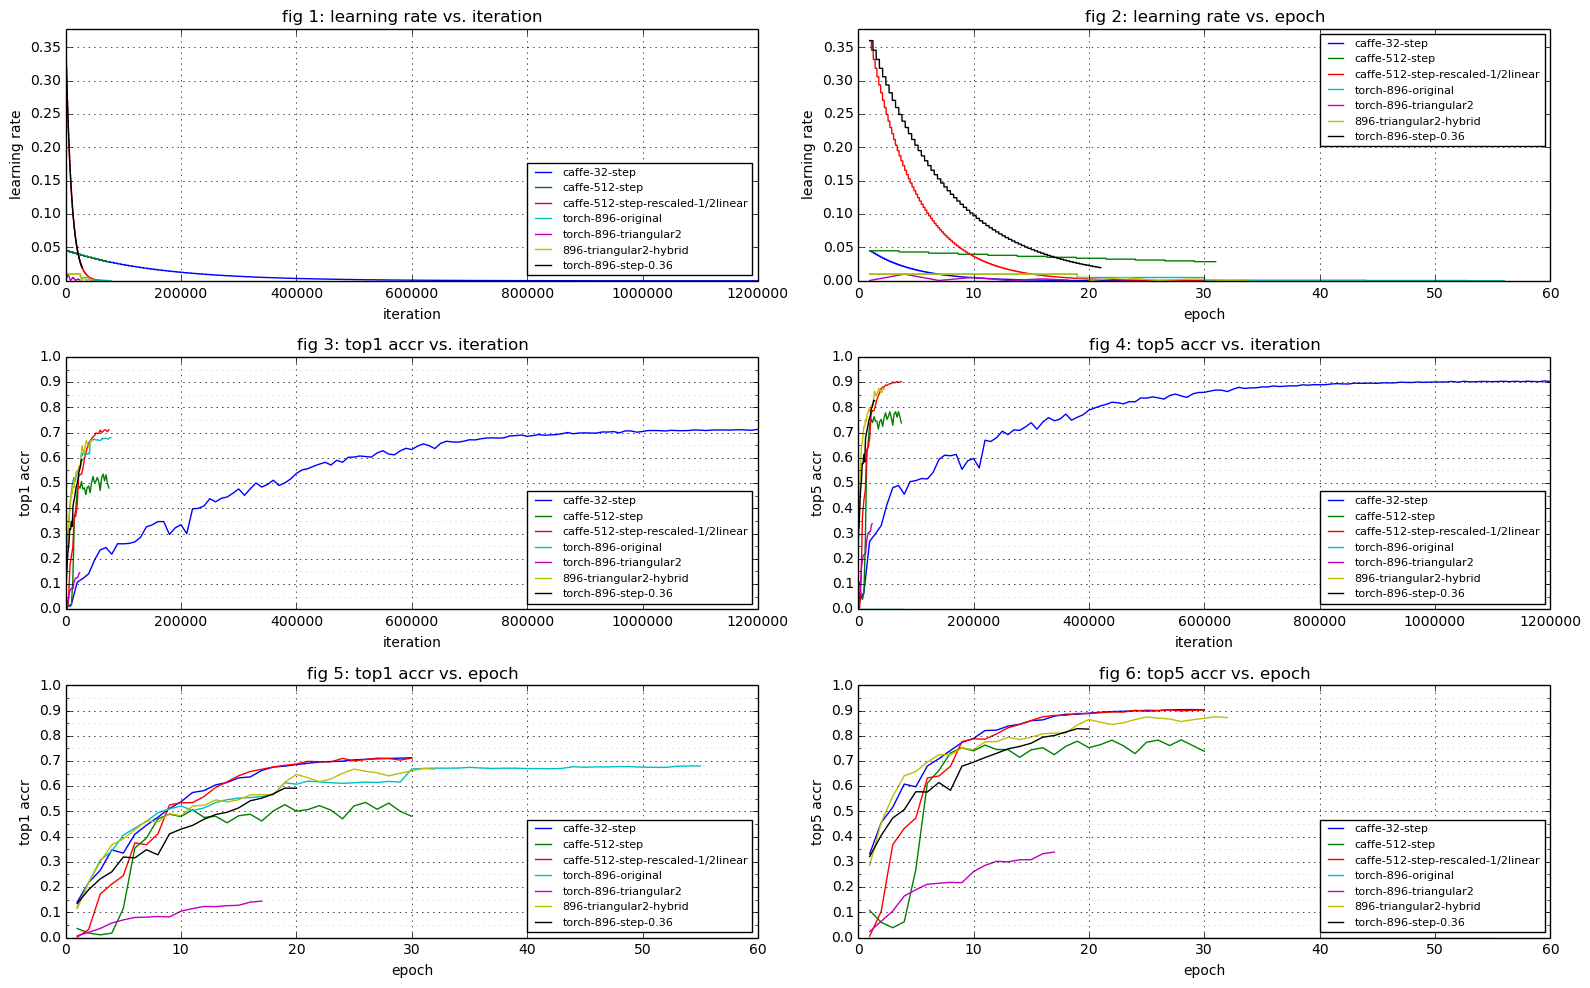

In [17]:
lineformats = plot_formats(len(result_tbls))
#plot the learning curve of one epoch
plt.figure(1,figsize=(16,10))
plt.title('Caffe Results')

plot_lr_iter(321,result_tbls,lineformats)
plot_lr_epoch(322,result_tbls,lineformats)
plot_top1_iter(323,result_tbls,lineformats)
#plot_loss_iter(323,result_tbls,lineformats)
plot_top5_iter(324,result_tbls,lineformats)
plot_top1_epoch(325,result_tbls,lineformats)
#plot_loss_epoch(325,result_tbls,lineformats)
plot_top5_epoch(326,result_tbls,lineformats)

plt.tight_layout()

find_final_accuracy(tests,result_tbls)
